# Imports

In [1]:
import pandas as pd
import numpy as np
import antiquated_data_processing_pipeline
import project_metrics
import matplotlib.pyplot as plt


from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#need to import a scoring metric here
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [2]:
pd.set_option('display.max_rows', None)        # show all rows
pd.set_option('display.max_columns', None)     # show all cols
pd.set_option('display.max_colwidth', None)    # don’t truncate long strings
pd.set_option('display.width', 0)              # auto-detect console width
pd.options.display.max_seq_items = None        # don’t elide long lists in cells

# Functions

# Data + Pre-Processing

## Builders

In [3]:
base_df = antiquated_data_processing_pipeline.run_base_df()

base_df.head()

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training
Post merge cleaning with 2nd interpolation of oil pricing...
Corresponding null count of df is: date                         0
store_nbr                    0
family                       0
sales                        0
onpromotion                  0
city                         0
state                        0
store_type                   0
store_cluster                0
transactions                 0
dol_per_barrel          807279
holiday_type           2346168
locale                 2346168
locale_name            2346168
holiday_description    2346168
transferred            2346168
dtype: int64


date  store_nbr      family  sales  onpromotion     city        state  \
0 2013-01-01         25  AUTOMOTIVE    0.0            0  Salinas  Santa Elena   
1 2013-01-01         25   BABY CARE    0.0            0  Salinas  Santa Elena   
2 2013-01-01         25      BEAUTY    2.0            0  Salinas  Santa Elena   
3 2013-01-01         25   BEVERAGES  810.0            0  Salinas  Santa Elena   
4 2013-01-01         25       BOOKS    0.0            0  Salinas  Santa Elena   

  store_type  store_cluster  transactions  dol_per_barrel holiday_type  \
0          D              1           770             NaN      Holiday   
1          D              1           770             NaN      Holiday   
2          D              1           770             NaN      Holiday   
3          D              1           770             NaN      Holiday   
4          D              1           770             NaN      Holiday   

     locale locale_name holiday_description transferred  \
0  National     Ecuador  Primer dia del ano       False   
1  National     Ecuador  Primer dia del ano       False   
2  National     Ecuador  Primer dia del ano       False   
3  National     Ecuador  Primer dia del ano       False   
4  National     Ecuador  Primer dia del ano       False   

   rolling_30day_avg_traffic  rolling_15day_avg_traffic  
0                      770.0                      770.0  
1                      770.0                      770.0  
2                      770.0                      770.0  
3                      770.0                      770.0  
4                      770.0                      770.0

NOTES ABOUT THE CLEANING

## Scoring

Mean Anbolute Scaled Error (MASE) is a scoring metric good for our timeseries data and forecasting approaches as it ratios the Mean Absolute Error (MAE) of a model against its naively assumed MAE (called this $\text{MAE}_\alpha$). Thus the resulting equation for MASE is as follows:

$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

We focus first on a naive MAE which is computed based on naive forecasting. Naive forecasting is is a simplistic approach towards forecasting which makes the assumption that a future value remain mostly unchanged from the last previous value - ergo it does not take into account exogenous conditions and featuress that may influence the trend of a value over time. Naive forecasting is done often for establishing a benchmark or baseline.

For the purpose of this project, we are going to construct our own function that we can use for measuring the MASE of our predictions. 

We start with showcasing the formula for the naive MAE, $\text{MAE}_\alpha$. This specific formula looks over an entire duration of timesteps...

$$
\text{MAE}_\alpha = \frac{1}{N-1} \sum_{i = 2}^{N} \text{abs}(y_i - y_{i-1})
$$

Now if we incorporate a seasonal variation from the forecast, we would then equate the forecast to an actual value from the period, but from the previous season corresponding to the current period (i.e. this year vs last year)...

Thus we have:

$$
\text{MAE}_\alpha = \frac{1}{N-m} \sum_{i = m+1}^{N} \text{abs}(y_i - y_{i-m})
$$

Above we cover the MAE for the naive forecast. To continue building our MASE metric, we would also leverage an MAE on our new algorithm meant to construct predictions (call then $o_n$$)

Therefore:

$$
\text{MAE} = \frac{1}{N}\sum_{j=1}^{N} \text{abs}(o_i - y_i)
$$


Finally, the MASE is then constructured from these error metrics as:


$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

As a ratio, MASE is measured around the value of 1. When the MAE from our model performs better than the MAE of the naive assumption, the MASE ratio goes below the value of 1. Above the value of one indicates our model's error is much stronger than the naive error, indicating the model performs very poorly. 


Sources: https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968

Sources: https://www.launchfulfillment.com/inventory-management-naive-forecasting/

# SARIMAX Re-attempt

## Old Attempt (New Scoring and Discussion of Issues)

The original study could not scale under its current modeling approaches. It practicality would be unfeasable given the model's inefficiency to generalize across multiple timeseries. Rather it theoretically "can" scale, but scaling in this inefficienct sense yields the need for an $M$ amount of models analyzing an $M$ amount of wanted categories to be forecasted upon. Sometimes, this way of wanting to forecast works well for companies as dedicated teams would likely be in charge of some models. But the issue comes with consistent training and fine-tuning, where manual hyperparameter tuning would be non-stop and constant to properly understand the exogenous factors of seasonal timeseries influenced data - or to accidentally achieve better scoring metrics through sheer luck. And as a company grows in its technological arsenal, more and more models would pollute a company's data analytics teams, each featuring different cases of feature engineering or manually set parameters to work with. It becomes too much to manage, versus a single or a few NN architectures, and minute code errors would possibly slide into forecasts. 

In these next cells, we highlight some small errors found in the previous project, as well as promote discussion on other places where tuning could occur.

In [4]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

In [5]:
X_train[
    X_train["dol_per_barrel"] == 0
]

dol_per_barrel  rolling_15day_avg_traffic  \
date_index                                              
2013-02-16             0.0                        0.0   
2013-02-17             0.0                        0.0   
2013-02-23             0.0                        0.0   
2013-02-24             0.0                        0.0   
2013-03-02             0.0                        0.0   
2013-03-03             0.0                        0.0   
2013-03-09             0.0                        0.0   
2013-03-10             0.0                        0.0   
2013-03-16             0.0                        0.0   
2013-03-17             0.0                        0.0   
2013-03-23             0.0                        0.0   
2013-03-24             0.0                        0.0   
2013-03-30             0.0                        0.0   
2013-03-31             0.0                        0.0   
2013-04-06             0.0                        0.0   
2013-04-07             0.0                        0.0   
2013-04-13             0.0                        0.0   
2013-04-14             0.0                        0.0   
2013-04-20             0.0                        0.0   
2013-04-21             0.0                        0.0   
2013-04-27             0.0                        0.0   
2013-04-28             0.0                        0.0   
2013-05-04             0.0                        0.0   
2013-05-05             0.0                        0.0   
2013-05-11             0.0                        0.0   
2013-05-12             0.0                        0.0   
2013-05-18             0.0                        0.0   
2013-05-19             0.0                        0.0   
2013-05-25             0.0                        0.0   
2013-05-26             0.0                        0.0   
2013-06-01             0.0                        0.0   
2013-06-02             0.0                        0.0   
2013-06-08             0.0                        0.0   
2013-06-09             0.0                        0.0   
2013-06-15             0.0                        0.0   
2013-06-16             0.0                        0.0   
2013-06-22             0.0                        0.0   
2013-06-23             0.0                        0.0   
2013-06-29             0.0                        0.0   
2013-06-30             0.0                        0.0   
2013-07-06             0.0                        0.0   
2013-07-07             0.0                        0.0   
2013-07-13             0.0                        0.0   
2013-07-14             0.0                        0.0   
2013-07-20             0.0                        0.0   
2013-07-21             0.0                        0.0   
2013-07-27             0.0                        0.0   
2013-07-28             0.0                        0.0   
2013-08-03             0.0                        0.0   
2013-08-04             0.0                        0.0   
2013-08-10             0.0                        0.0   
2013-08-11             0.0                        0.0   
2013-08-17             0.0                        0.0   
2013-08-18             0.0                        0.0   
2013-08-24             0.0                        0.0   
2013-08-25             0.0                        0.0   
2013-08-31             0.0                        0.0   
2013-09-01             0.0                        0.0   
2013-09-07             0.0                        0.0   
2013-09-08             0.0                        0.0   
2013-09-14             0.0                        0.0   
2013-09-15             0.0                        0.0   
2013-09-21             0.0                        0.0   
2013-09-22             0.0                        0.0   
2013-09-28             0.0                        0.0   
2013-09-29             0.0                        0.0   
2013-10-05             0.0                        0.0   
2013-10-06             0.0                        0.0   
2013-10-12            

Above we confirm that with nans set to 0, this has introduced a several crashes into our dataset. We will use a ffill on the nans instead, which will make a naive assumption for interpolation on the nans. In this case, the `dol_per_barrel` will assume a previous timestep price and replace the gaps with such value. 

Furthermore, filling nan's with 0's through this late `fillna()` command towards the end of our model processing script also introduced 0's across the board for a large variety of areas. We cannot simply drop the nulls as continuous timeseries data is needed for our SARIMAX model. Another issue is that we categorized some of our data....sending a 0 into those (if the entire nans spread across those rows). We will look at the peripheral rows of these problematic rows. 

In [6]:
zero_mask = X_train["dol_per_barrel"] == 0
zero_dates = X_train.index[zero_mask]


context_rows = []

for date in zero_dates:
    # Define a window around the specific date
    start_date = date - pd.Timedelta(days=2)
    end_date = date + pd.Timedelta(days=2)
    
    # Slice the dataframe to get the context
    # We use .loc to slice by the DateTime index
    context = X_train.loc[start_date:end_date].copy()
    
    # Optional: Add a 'flag' column to highlight the exact zero row in the printout
    context['is_zero_target'] = (context["dol_per_barrel"] == 0)
    
    context_rows.append(context)



if context_rows:
    inspection_df = pd.concat(context_rows)

    print(f"Found {len(zero_dates)} rows with 0 values.")
    print("Displaying these rows with their neighbors:\n")

    cols_to_view = ['dol_per_barrel', 'rolling_30day_avg_traffic', 'day_of_week_sine', 'is_zero_target']

    display(inspection_df[cols_to_view])
else:
    print("No rows with dol_per_barrel == 0 found.")

Found 471 rows with 0 values.
Displaying these rows with their neighbors:



dol_per_barrel  rolling_30day_avg_traffic  day_of_week_sine  \
date_index                                                                
2013-02-14       97.300000                3384.033333         -0.974928   
2013-02-15       95.950000                3388.833333         -0.781831   
2013-02-16        0.000000                   0.000000          0.000000   
2013-02-17        0.000000                   0.000000          0.000000   
2013-02-18       96.320000                3416.200000          0.974928   
2013-02-15       95.950000                3388.833333         -0.781831   
2013-02-16        0.000000                   0.000000          0.000000   
2013-02-17        0.000000                   0.000000          0.000000   
2013-02-18       96.320000                3416.200000          0.974928   
2013-02-19       96.690000                3372.633333          0.433884   
2013-02-21       92.790000                3373.266667         -0.974928   
2013-02-22       93.120000                3382.266667         -0.781831   
2013-02-23        0.000000                   0.000000          0.000000   
2013-02-24        0.000000                   0.000000          0.000000   
2013-02-25       92.740000                3424.166667          0.974928   
2013-02-22       93.120000                3382.266667         -0.781831   
2013-02-23        0.000000                   0.000000          0.000000   
2013-02-24        0.000000                   0.000000          0.000000   
2013-02-25       92.740000                3424.166667          0.974928   
2013-02-26       92.630000                3378.333333          0.433884   
2013-02-28       92.030000                3385.900000         -0.974928   
2013-03-01       90.710000                3402.200000         -0.781831   
2013-03-02        0.000000                   0.000000          0.000000   
2013-03-03        0.000000                   0.000000          0.000000   
2013-03-04       90.130000                3459.900000          0.974928   
2013-03-01       90.710000                3402.200000         -0.781831   
2013-03-02        0.000000                   0.000000          0.000000   
2013-03-03        0.000000                   0.000000          0.000000   
2013-03-04       90.130000                3459.900000          0.974928   
2013-03-05       90.880000                3424.366667          0.433884   
2013-03-07       91.530000                3420.500000         -0.974928   
2013-03-08       92.010000                3429.500000         -0.781831   
2013-03-09        0.000000                   0.000000          0.000000   
2013-03-10        0.000000                   0.000000          0.000000   
2013-03-11       92.070000                3476.333333          0.974928   
2013-03-08       92.010000                3429.500000         -0.781831   
2013-03-09        0.000000                   0.000000          0.000000   
2013-03-10        0.000000                   0.000000          0.000000   
2013-03-11       92.070000                3476.333333          0.974928   
2013-03-12       92.440000                3462.866667          0.433884   
2013-03-14       93.030000                3418.266667         -0.974928   
2013-03-15       93.490000                3419.000000         -0.781831   
2013-03-16        0.000000                   0.000000          0.000000   
2013-03-17        0.000000                   0.000000          0.000000   
2013-03-18       93.710000                3441.333333          0.974928   
2013-03-15       93.490000                3419.000000         -0.781831   
2013-03-16        0.000000                   0.000000          0.000000   
2013-03-17        0.000000                   0.000000          0.000000   
2013-03-18       93.710000                3441.333333          0.974928   
2013-03-19       92.440000                3418.933333          0.433884   
2013-03-21       92.460000                3420.866667         -0.974928   
2013-03-22       93.410000           

In [7]:
# Count how many rows are flagged as the "Zero Target"
print(f"Count of Zero-Target rows: {inspection_df['is_zero_target'].sum()}")

Count of Zero-Target rows: 951


In [8]:
base_df.isna().sum()

date                               0
store_nbr                          0
family                             0
sales                              0
onpromotion                        0
city                               0
state                              0
store_type                         0
store_cluster                      0
transactions                       0
dol_per_barrel                807279
holiday_type                 2346168
locale                       2346168
locale_name                  2346168
holiday_description          2346168
transferred                  2346168
rolling_30day_avg_traffic          0
rolling_15day_avg_traffic          0
dtype: int64

Above, we note some important places to discuss. The base dataframe still contains several nulls...but the most important ones to note are the ones contained in the `dol_per_barrel` column. With 33 nulls, this means an interpolation issue persists.  

However, going back on the previous project's notes, the interpolation was initially left in the post-merge (created `base_df` as it stands). Initially forgotten about, but the reason for this was to showcase a plot of a post-merge interpolation leftover (something that happened from performing an "outer merge" of the `oil` dataframe and its dated time-steps against the `training` set's time-steps). 

To discuss further, let's recount the issues with the `oil` dataframe - how missing data on important dates creates a lot of guess work in terms of interpolation. We will show the pre merged and post merged oil dataframe relaying on interpolated backfilled values.

In [9]:
oil = pd.read_csv("../data/oil.csv")
oil["date"] = pd.to_datetime(oil["date"])
display(oil.isnull().any())
print("--------")
display(oil.isnull().sum())



# oil_date_range = oil["date"].to_list()

# # We're going to pull oil sub-dfs
# # into a list and then iteratively
# # subplot them
# oil_sub_dfs = []

# plot_oil = oil.copy()

# # plot_oil["group"] = plot_oil["dcoilwtico"].notnull().cumsum() * plot_oil["dcoilwtico"].notnull()

# plot_oil["group"] = (plot_oil["dcoilwtico"].notnull() != plot_oil["dcoilwtico"].notnull().shift()).cumsum() * plot_oil["dcoilwtico"].notnull()



# groups = plot_oil[ plot_oil["dcoilwtico"].notnull() ].groupby("group")

# plot_oil = plot_oil[ plot_oil["group"] != 0 ]

# n_groups = groups.ngroups

# # fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
# plt.figure( figsize=(11.69,8.27) )

# # for (group_id, group_data), ax in zip(groups, axes):
# for group_id, group_data in groups:
#     plt.plot(group_data["date"], group_data["dcoilwtico"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

# plt.title("Piecewise Representation of Oil Prices over Time", size=25, fontweight="bold")
# plt.xlabel("Year", size=20, fontweight="bold")
# plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

# plt.xticks(size="20")
# plt.yticks(size="18")
# plt.grid(axis="both")


# plt.savefig("../new_images/oil_piecewise_over_time.png", format="png", dpi=300)

# # plt.grid

date          False
dcoilwtico     True
dtype: bool

--------


date           0
dcoilwtico    43
dtype: int64

In [10]:
# plot_oil = oil.copy()



# plot_oil = plot_oil.interpolate(method="linear")

# plt.figure( figsize=(11.69,8.27) )
# plt.plot(plot_oil["date"], plot_oil["dcoilwtico"])


# plt.title("Interpolated Representation of Oil Prices over Time", size=25, fontweight="bold")
# plt.xlabel("Year", size=20, fontweight="bold")
# plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

# plt.xticks(size="20")
# plt.yticks(size="18")
# plt.grid(axis="both")

# plt.savefig("../new_images/oil_interpolated_over_time.png", format="png", dpi=300)

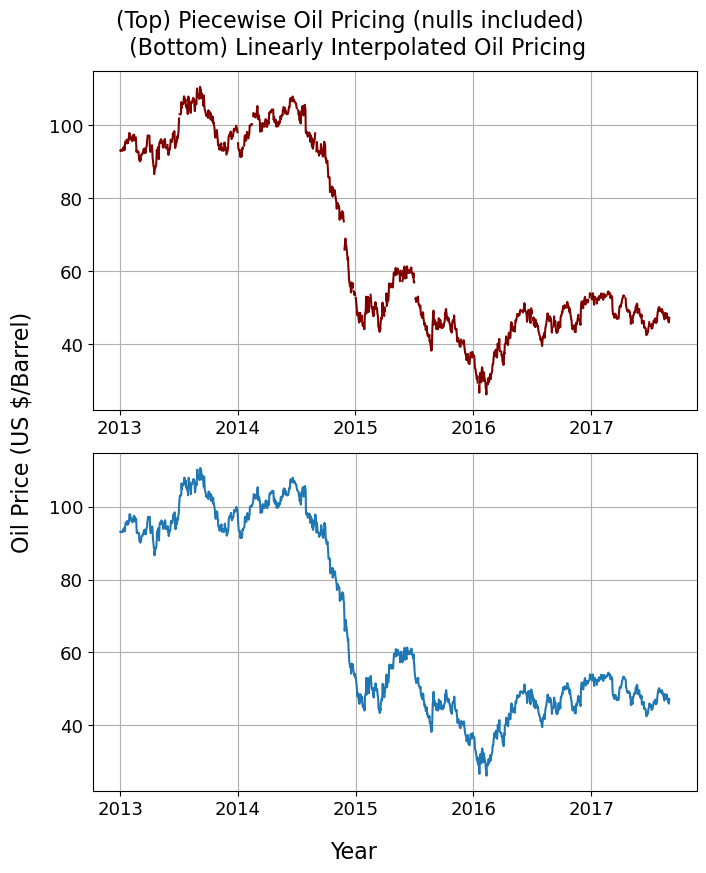

In [11]:
##For Grouped
grouped_plot_oil = oil.copy()

grouped_plot_oil["group"] = (grouped_plot_oil["dcoilwtico"].notnull() != grouped_plot_oil["dcoilwtico"].notnull().shift()).cumsum() * grouped_plot_oil["dcoilwtico"].notnull()

groups = grouped_plot_oil[ grouped_plot_oil["dcoilwtico"].notnull() ].groupby("group")

grouped_plot_oil = grouped_plot_oil[ grouped_plot_oil["group"] != 0 ]

n_groups = groups.ngroups

#For interpolated
interpolated_plot_oil = oil.copy()
interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear").ffill().bfill()
# interpolated_plot_oil = interpolated_plot_oil.interpolate(method="time")



##Figure creation
fig, ax = plt.subplots(2, 1, figsize=(7.16, 8.8))#figsize=(11.69,8.27))

for group_id, group_data in groups:
    ax[0].plot(group_data["date"], group_data["dcoilwtico"], color="maroon", label=f"Oil Price Group {group_id}")

ax[1].plot(interpolated_plot_oil["date"], interpolated_plot_oil["dcoilwtico"])


for index, a in enumerate(ax.flat):
    # Change the font weight of the x-ticks and y-ticks
    a.tick_params(axis='x', labelsize=13)  # Bold x-ticks
    a.tick_params(axis='y', labelsize=13)  # Bold y-ticks


ax[0].grid(which="both")
ax[1].grid(which="both")


plt.suptitle("(Top) Piecewise Oil Pricing (nulls included) \n (Bottom) Linearly Interpolated Oil Pricing", size=16)
fig.supylabel("Oil Price (US $/Barrel)", fontsize=16)
fig.supxlabel("Year", fontsize=16)
plt.tight_layout()

plt.savefig("../images/base_oil_pre_post_interpolation.png", format="png", dpi=300)

The above showcases how oil existed before and then after with linear interpolation and inclusive of forward and backfilling on specific edge cases. Oil's values were interpolated in this manner before the merge to create a pliable base dataframe. Important to re-highlight this interpolation happened before the merge. 

Post merge, further interpolation was needed. In this case below, we chose to briefly omit the line of code on the more permanent interpolation found within the data processing pipeline to generate a plot of yet another piecewise comparison of the oil plot. The plot was stored within the `new_images` directory (hidden within the `.gitignore`). However, for submission of the project, the folder will be provided. And for the sake of convenience, we leave the code to generate such plot below uncommented, except for the line that overwrites a save for the specific picture. This code will not re-generate the plot due to its reliance on an unclean base dataframe from the data processing pipeline. However, a Markdown cell calling upon the proper plot is shown below. 

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_6206/945652502.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


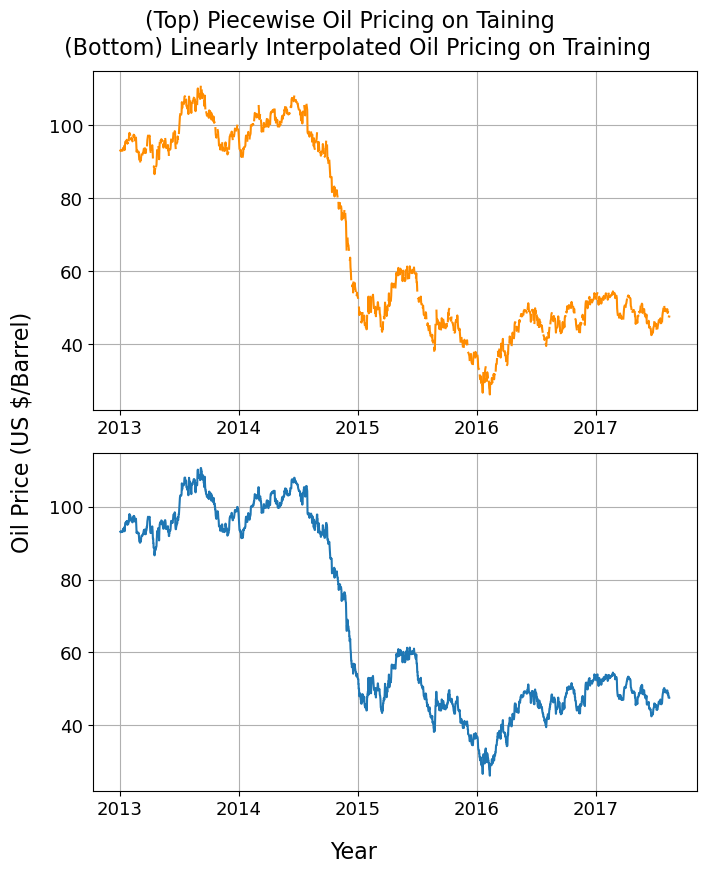

In [ ]:
##Notice that these plots won't show piecewise representation anymore
##Because the base_df has pre-interpolated values
##This interpolation line will need to be commented out in the oil cleaning funciton if the desire is to have a piecewise representation again for these plots. 

##For Grouped
grouped_plot_oil = base_df.copy()

grouped_plot_oil["group"] = (grouped_plot_oil["dol_per_barrel"].notnull() != grouped_plot_oil["dol_per_barrel"].notnull().shift()).cumsum() * grouped_plot_oil["dol_per_barrel"].notnull()

groups = grouped_plot_oil[ grouped_plot_oil["dol_per_barrel"].notnull() ].groupby("group")

grouped_plot_oil = grouped_plot_oil[ grouped_plot_oil["group"] != 0 ]

n_groups = groups.ngroups

#For interpolated
interpolated_plot_oil = base_df.copy()
interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


##Figure creation
fig, ax = plt.subplots(2, 1, figsize=(7.16, 8.8))#figsize=(11.69,8.27))

for group_id, group_data in groups:
    ax[0].plot(group_data["date"], group_data["dol_per_barrel"], color="darkorange", label=f"Oil Price Group {group_id}")

ax[1].plot(interpolated_plot_oil["date"], interpolated_plot_oil["dol_per_barrel"])


for index, a in enumerate(ax.flat):
    # Change the font weight of the x-ticks and y-ticks
    a.tick_params(axis='x', labelsize=13)  # Bold x-ticks
    a.tick_params(axis='y', labelsize=13)  # Bold y-ticks


ax[0].grid(which="both")
ax[1].grid(which="both")


plt.suptitle("(Top) Piecewise Oil Pricing on Taining \n (Bottom) Linearly Interpolated Oil Pricing on Training", size=16)
fig.supylabel("Oil Price (US $/Barrel)", fontsize=16)
fig.supxlabel("Year", fontsize=16)
plt.tight_layout()

# plt.savefig("../new_images/training_oil_pre_post_interpolation.png", format="png", dpi=300)

Observe the nulls in the base dataframe - a result of joining the already interpolated oil dataframe to the training data. The need for further interpolation was due to the lack of full dates provided within our oil dataframe unable to match the granularity of our timesteps within our training set.

Furthermore, note the counts of redundant named column value pairings. We will remove such columns. These columns as constans serve no purpose in a univariate model (i.e. they only increase the model complexity as a consideration for additional features.)

![Training Data Based Interpolation](../new_images/training_oil_pre_post_interpolation.png)

So now the ultimate question.....if `X_train`, `y_train`, `X_test`, and `y_test` are based on the `base_df` and we have corrected our original `oil` dataframe with interpolated values AS WELL as corrected the merge with interpolated values, why are these modeling based dataframes still yielding nulls needing to be corrected? Backfilling and forwardfilling and linear interpolation are all techniques we used to help decide fill in the gaps of our timesteps (only along the `dol_per_barrel` column we created), but the nulls are specifically introduced due to one problematic line in particular. Let us run a `debug` version of our single model pre-process (or otherwise known as the `debug_single_model_pre_process()`) functionl located within the `antiquated_data_processing_pipeline.py`. 

In [21]:
base_df[
    (base_df["store_nbr"] == 45) &
    (base_df["family"] == "GROCERY I")
][["store_nbr", "city", "state", "store_type"]].value_counts()

store_nbr  city   state      store_type
45         Quito  Pichincha  A             1707
Name: count, dtype: int64

In [ ]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


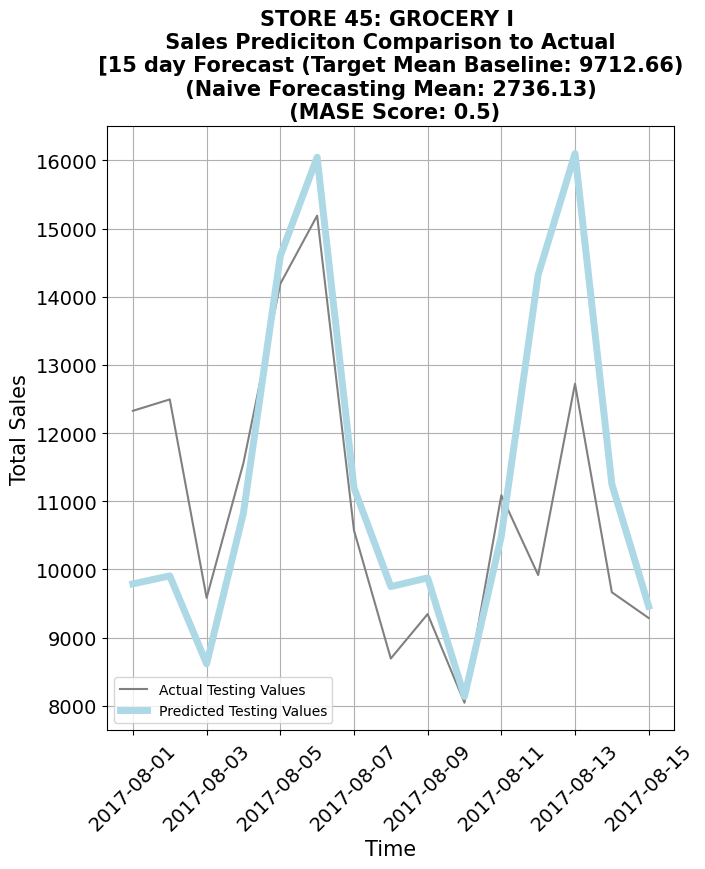

In [ ]:
VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

## Old Problem and Re-execution

## Model Packaging and Deployment onto Other Categories